In [3]:
# Imports 
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.layers import PReLU
from tensorflow import keras as keras
from tensorflow.keras.layers import concatenate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

## Imports
import pandas as pd
import cv2 as cv
import scipy.io as sio

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
tf.test.is_built_with_cuda()
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.70)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs: 1


In [5]:
number_of_items = 100000000000000
resize_Width = int(1920 / 4)
resize_Height = int(1080 / 4)
def getData(direct_path, batch_size):
    # Path for images and GT
    imgPath = direct_path + "\\" + "train_img"
    gtPath = direct_path + "\\" + "train_gt"
    # Load list of files in specified directory
    Imgfiles=os.listdir(imgPath)
    GTfiles=os.listdir(gtPath)
    # Assign Lists to append to
    for index in range(0,number_of_items,batch_size):
        Images = []
        GT = []
        counts = []
        offset = index % 1000
        for i in range(batch_size):
            # Read Image and matlab GT files
            image  = np.array(cv.imread(imgPath + "\\" + Imgfiles[offset + i]))
            curGT  = np.array(sio.loadmat(gtPath + "\\" + GTfiles[offset + i])['point'])

            # Turn points into density map
            x = curGT[:,0]
            y = curGT[:,1]
            rounded = np.round([x,y]).astype('int').transpose()
            density = np.zeros((1080, 1920))
            size = 50
            for ix, iy in rounded:
                density[iy:iy+size,ix:ix+size] = 1

            # Append to existing lists
            Images.append(cv.resize(image, (resize_Width, resize_Height))) 
            GT.append(cv.resize(density, (resize_Width, resize_Height)))
            counts.append(len(curGT))
        
        # Output with x and y datasets.
        yield np.array(Images), [np.array(GT), np.array(counts)]

In [6]:
with tf.device('/cpu:0'):
    # Model
    inputs = keras.Input(shape=(resize_Height, resize_Width, 3, ), name='img')
    ## Base Layer
    x = layers.Conv2D(filters=16, kernel_size=(9,9), padding="same", activation=PReLU())(inputs)
    x = layers.Conv2D(filters=32, kernel_size=(7,7), padding="same", activation=PReLU())(x)

    ## High-level Priority Stage
    HP = layers.Conv2D(filters=16,kernel_size=(9,9), padding="same", activation=PReLU())(x)
    HP = layers.MaxPool2D(pool_size=(2, 2))(HP)
    HP = layers.Conv2D(filters=32,kernel_size=(7,7), padding="same", activation=PReLU())(HP)
    HP = layers.MaxPool2D(pool_size=(2, 2))(HP)
    HP = layers.Conv2D(filters=16,kernel_size=(7,7), padding="same", activation=PReLU())(HP)
    HP = layers.Conv2D(filters=8,kernel_size=(7,7), padding="same", activation=PReLU())(HP)

    ## Classification Output
    CO = layers.GlobalMaxPool2D()(HP)
    CO = layers.Flatten()(CO)
    CO = layers.Dense(512, activation='relu')(CO)
    CO = layers.Dense(256, activation='relu')(CO)
    OutputClass = layers.Dense(1, activation='relu')(CO)

    ## Density Estimator
    ## Stage 1

    DE = layers.Conv2D (filters=20, kernel_size=(7,7), padding="same", activation=PReLU())(x)
    DE = layers.MaxPool2D(pool_size=(2, 2))(DE)
    DE = layers.Conv2D (filters=40, kernel_size=(5,5), padding="same", activation=PReLU())(DE)
    DE = layers.MaxPool2D(pool_size=(2, 2))(DE)
    DE = layers.Conv2D (filters=20, kernel_size=(5,5), padding="same", activation=PReLU())(DE)
    DE = layers.Conv2D (filters=10, kernel_size=(5,5), padding="same", activation=PReLU())(DE)

    ## Stage 2
    DE_HP = concatenate([DE, HP])
    DE = layers.Conv2D(filters=24, kernel_size=(3,3), padding="same", activation=PReLU())(DE_HP)
    DE = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=PReLU())(DE)

    DE = layers.Conv2DTranspose(filters=16, kernel_size=(4,4), padding="same", use_bias=True)(DE)
    DE = layers.PReLU()(DE)
    DE = layers.Conv2DTranspose(filters=8, kernel_size=(4,4), padding="same", use_bias=True)(DE)
    DE = layers.PReLU()(DE)

    DE = layers.UpSampling2D (size=(4, 4))(DE)
    DE = layers.ZeroPadding2D(padding=(1,0))(DE)
    DE = layers.Conv2D (filters=1, kernel_size=(1,1), padding="same", activation='relu')(DE)


    # note both outputs defined here
    model_cnn = keras.Model(inputs=inputs, outputs=[DE, OutputClass], name='Assign2Model')
    model_cnn.summary()

Model: "Assign2Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 270, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 270, 480, 16) 2077504     img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 270, 480, 32) 4172320     conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 270, 480, 20) 2623380     conv2d_1[0][0]                   
_______________________________________________________________________________________

In [7]:
# train_path = './data/train_data'
# trainx, trainGT, trainy = getData(train_path, 0)
# valx, valGT, valy = getData(train_path, 10)

# trainx = np.array(trainx)
# trainGT= np.array(trainGT)
# trainy = np.array(trainy)
# valx = np.array(valx)
# valGT= np.array(valGT)
# valy = np.array(valy)

# print(trainy)
# print(valy)



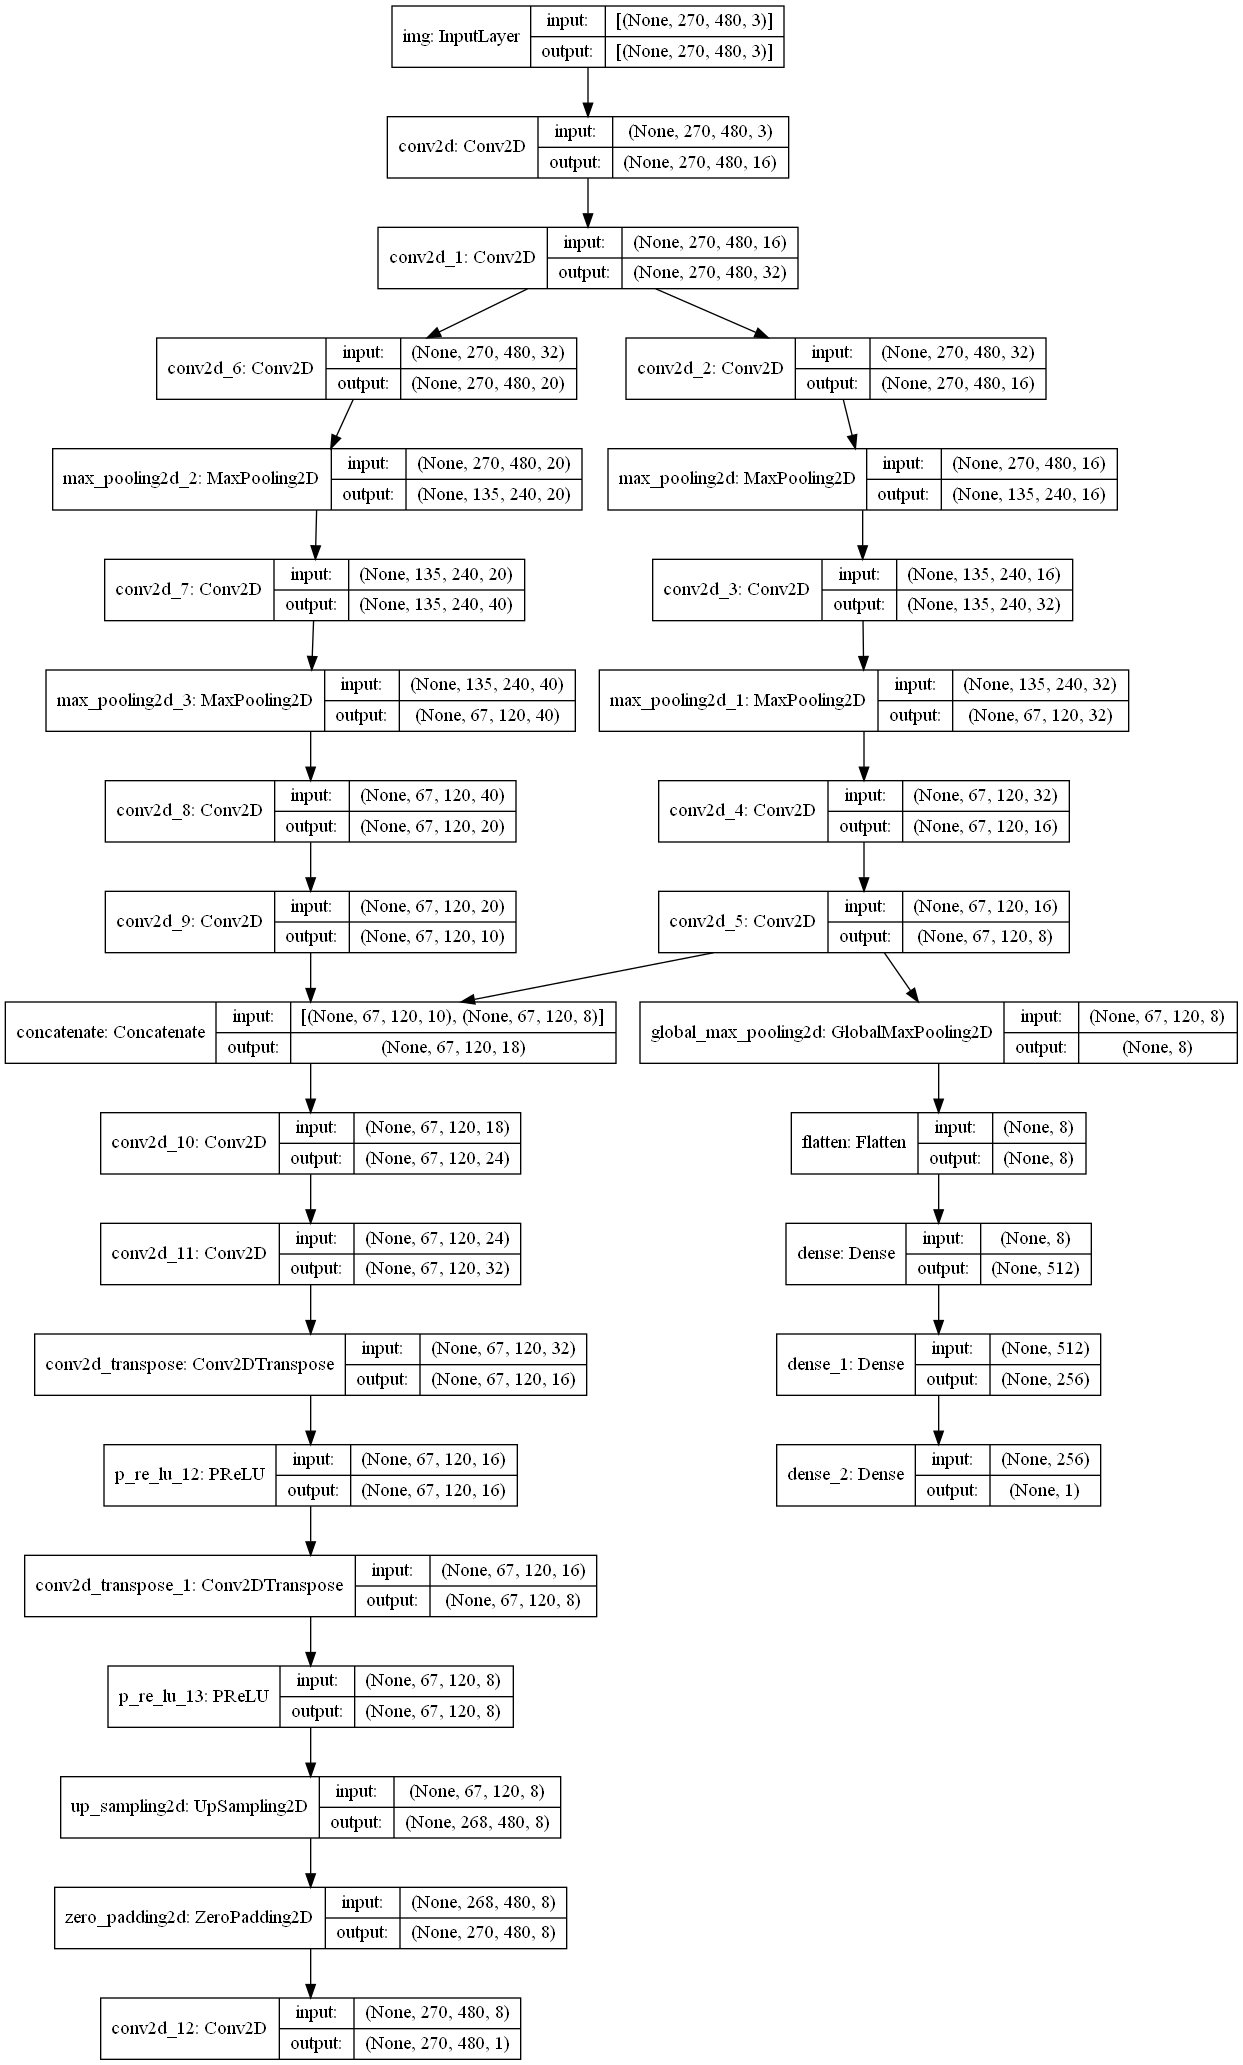

In [8]:
#Show model
plot_model(model_cnn, to_file='Assignment2_v2.png', show_shapes=True)
IPython.display.Image('Assignment2_v2.png')

In [9]:
def density_loss2(y_true, y_pred):
    # Data is passed in by the batch
    batch_loss = []
    # Each item in batch
    for i in range(2):
        sub = y_true[i] - y_pred[i]
        loss = 0
        # Each pixel
        for y in range(540):
            for x in range(960):
                loss += abs(sub[y,x])
        batch_loss[i] = loss
    return batch_loss

In [10]:
def l2_loss(y_true, y_pred):

    y_true = K.repeat_elements(y_true, rep=5, axis=-1)
 
    loss = K.mean(K.square(y_true - y_pred))

    return loss

In [11]:
# Custom loss example for keras: https://keras.io/api/losses/ (scroll down to custom loss)
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

def CrossEntropy(yHat, y):
    if y == 1:
      return -log(yHat)
    else:
      return -log(1 - yHat)
model_cnn.compile(optimizer='adam', loss=['mse','mse'])
##model_cnn.fit()

In [12]:
## Model fit
generator = getData('./data/train_data', 20)

with tf.device('/gpu:0'):
    modelTrainHist = model_cnn.fit(generator,
                        epochs=10,
                        batch_size=20,
                        steps_per_epoch=60,
                        validation_split=0.1)
                        )
    !mkdir -p saved_model
    model_cnn.save('saved_model/my_model')
model_cnn = tf.keras.models.load_model('saved_model/my_model')

Epoch 1/10
60/60 [==============================] - 127s 906ms/step - loss: 6569.8130 - conv2d_12_loss: 0.0555 - dense_2_loss: 6569.7586
Epoch 2/10
60/60 [==============================] - 56s 931ms/step - loss: 6266.4005 - conv2d_12_loss: 0.0544 - dense_2_loss: 6266.3465
Epoch 3/10
60/60 [==============================] - 62s 1s/step - loss: 6153.3748 - conv2d_12_loss: 0.0546 - dense_2_loss: 6153.3204
Epoch 4/10
60/60 [==============================] - 53s 886ms/step - loss: 6773.9501 - conv2d_12_loss: 0.0573 - dense_2_loss: 6773.8930
Epoch 5/10
60/60 [==============================] - 53s 886ms/step - loss: 6156.5400 - conv2d_12_loss: 0.0559 - dense_2_loss: 6156.4848
Epoch 6/10
60/60 [==============================] - 53s 886ms/step - loss: 6225.1380 - conv2d_12_loss: 0.0552 - dense_2_loss: 6225.0835
Epoch 7/10
60/60 [==============================] - 55s 916ms/step - loss: 6266.4005 - conv2d_12_loss: 0.0544 - dense_2_loss: 6266.3465
Epoch 8/10
60/60 [==============================] 

In [13]:
input = next(generator)
image = model_cnn.predict(tf.expand_dims(input[0][0], axis=0))
print(input)

(array([[[[ 20,  27,  27],
         [ 14,  20,  20],
         [ 14,  19,  19],
         ...,
         [255, 255, 254],
         [255, 255, 254],
         [255, 255, 254]],

        [[ 22,  29,  29],
         [ 16,  21,  21],
         [ 14,  18,  18],
         ...,
         [255, 255, 254],
         [255, 255, 254],
         [255, 255, 254]],

        [[ 20,  27,  27],
         [ 14,  20,  20],
         [ 18,  21,  21],
         ...,
         [255, 255, 254],
         [255, 255, 254],
         [255, 255, 254]],

        ...,

        [[ 64,  59,  59],
         [ 48,  43,  43],
         [ 38,  33,  33],
         ...,
         [ 89, 124, 222],
         [ 92, 125, 217],
         [104, 135, 217]],

        [[ 56,  51,  51],
         [ 32,  27,  27],
         [ 50,  44,  44],
         ...,
         [ 79, 112, 211],
         [ 81, 113, 211],
         [ 89, 118, 210]],

        [[ 31,  26,  26],
         [ 45,  40,  40],
         [ 61,  56,  56],
         ...,
         [ 63,  84, 185],
       

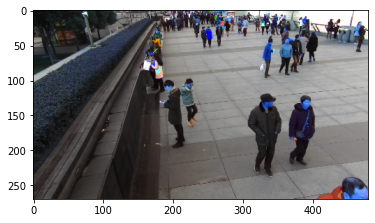

In [14]:
plt.imshow(input[0][0])


[145.93735]


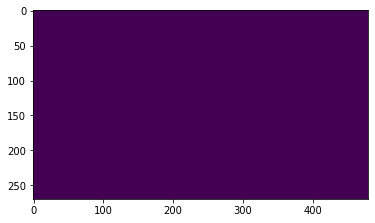

In [115]:
print(image[1][0])
plt.imshow(image[0][0])